## Package imports

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

## Import data

In [3]:
data = pd.read_parquet('./input/consumer_complaints.parquet')
data.head(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",None,None,None,U.S. Bancorp,CA,95993,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",None,None,None,Wells Fargo & Company,CA,91104,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,None,Incorrect information on credit report,Account status,None,None,Wells Fargo & Company,NY,11764,None,None,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,None,None,"Navient Solutions, Inc.",MD,21402,None,None,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,None,None,Resurgent Capital Services L.P.,GA,30106,None,None,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
5,08/30/2013,Credit card,None,Application processing delay,None,None,None,Capital One,NY,12206,None,None,Phone,09/03/2013,Closed with explanation,Yes,Yes,510098
6,08/30/2013,Credit card,None,Credit line increase/decrease,None,None,None,Wells Fargo & Company,AZ,85730,None,None,Postal mail,09/05/2013,Closed with explanation,Yes,No,511062
7,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,IL,60660,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511116
8,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,GA,30016,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511091
9,09/17/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",None,None,None,"SunTrust Banks, Inc.",CA,94551,None,None,Web,09/18/2013,Closed with explanation,Yes,Yes,530602


In [4]:
# Only keep records with a complaint narrative for NLP
# Will reduce dataset from over a half million to ~67k, which is still well sized 
data = data[~data['consumer_complaint_narrative'].isnull()].reset_index(drop=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   product                       66806 non-null  object
 2   sub_product                   46351 non-null  object
 3   issue                         66806 non-null  object
 4   sub_issue                     32932 non-null  object
 5   consumer_complaint_narrative  66806 non-null  object
 6   company_public_response       32776 non-null  object
 7   company                       66806 non-null  object
 8   state                         66620 non-null  object
 9   zipcode                       66617 non-null  object
 10  tags                          11417 non-null  object
 11  consumer_consent_provided     66806 non-null  object
 12  submitted_via                 66806 non-null  object
 13  date_sent_to_com

In [6]:
# Move target (product) column to end, where I like it :)
col_at_end = ['product']
data = data[[c for c in data if c not in col_at_end] 
        + [c for c in col_at_end if c in data]]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   sub_product                   46351 non-null  object
 2   issue                         66806 non-null  object
 3   sub_issue                     32932 non-null  object
 4   consumer_complaint_narrative  66806 non-null  object
 5   company_public_response       32776 non-null  object
 6   company                       66806 non-null  object
 7   state                         66620 non-null  object
 8   zipcode                       66617 non-null  object
 9   tags                          11417 non-null  object
 10  consumer_consent_provided     66806 non-null  object
 11  submitted_via                 66806 non-null  object
 12  date_sent_to_company          66806 non-null  object
 13  company_response

In [8]:
data.head()

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,product
0,03/19/2015,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516,Debt collection
1,03/19/2015,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492,Consumer Loan
2,03/19/2015,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,Mortgage
3,03/19/2015,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,I have an open and current mortgage with Chase...,None,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253,Mortgage
4,03/19/2015,Conventional fixed mortgage,Credit decision / Underwriting,None,XXXX was submitted XX/XX/XXXX. At the time I s...,None,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,Mortgage


In [9]:
data.tail()

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,product
66801,02/10/2016,None,Incorrect information on credit report,Account status,"XXXX XXXX is reporting incorrectly, payments h...",Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,None,Consent provided,Web,02/10/2016,Closed with explanation,Yes,No,1782682,Credit reporting
66802,02/10/2016,None,Incorrect information on credit report,Account status,Reflecting incorrect payment status. Have been...,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",WA,980XX,None,Consent provided,Web,02/10/2016,Closed with explanation,Yes,No,1781861,Credit reporting
66803,02/11/2016,Payday loan,Charged fees or interest I didn't expect,Charged fees or interest I didn't expect,I have been paying {$180.00} a month through d...,None,Zarvad III S.A.,NV,891XX,Servicemember,Consent provided,Web,02/11/2016,Closed with explanation,Yes,No,1782804,Payday loan
66804,03/30/2016,Conventional fixed mortgage,"Application, originator, mortgage broker",None,I recently became aware that Amerisave Mortgag...,Company believes it acted appropriately as aut...,Amerisave,AZ,853XX,None,Consent provided,Web,03/30/2016,Closed with explanation,Yes,Yes,1855199,Mortgage
66805,02/12/2016,Conventional fixed mortgage,"Application, originator, mortgage broker",None,Bank of America has demonstrated an on-going l...,Company has responded to the consumer and the ...,Bank of America,GA,300XX,None,Consent provided,Web,02/12/2016,Closed with explanation,Yes,Yes,1786225,Mortgage


## Split data into training, validation, and test datasets

In [10]:
# Use stratified shuffle split to keep same class proportions in train, validation, and test datasets.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=2023)

In [11]:
col_names = ['date_received', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 
             'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 
             'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id'] 
target_name = ['product']

In [12]:
# Separate target (product) from rest of df_train_train to mitigate any data leakage. Convert to X, y values for splitting.
X_0 = data.drop(['product'],axis=1).values
y_0 = data['product'].values

In [13]:
# Split out training data and set aside notTrain data to be further split into validation and test datasets.
for train_index, notTrain_index in sss.split(X_0, y_0):
    print("TRAIN:", train_index, "notTrain:", notTrain_index)
    df_train, df_notTrain = pd.DataFrame(X_0[train_index], columns=col_names), pd.DataFrame(X_0[notTrain_index], columns=col_names)
    y_train, y_notTrain = pd.DataFrame(y_0[train_index], columns=target_name), pd.DataFrame(y_0[notTrain_index], columns=target_name)

TRAIN: [66532 50895 42628 ... 28892 50019 29706] notTrain: [60595 22367 24282 ... 62846 37483 11606]
TRAIN: [59338 36899 41681 ... 19526  1461  4941] notTrain: [65569 32378 21315 ... 13714 37343  6037]


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 46764 non-null  object
 1   sub_product                   32446 non-null  object
 2   issue                         46764 non-null  object
 3   sub_issue                     23052 non-null  object
 4   consumer_complaint_narrative  46764 non-null  object
 5   company_public_response       22930 non-null  object
 6   company                       46764 non-null  object
 7   state                         46628 non-null  object
 8   zipcode                       46626 non-null  object
 9   tags                          7952 non-null   object
 10  consumer_consent_provided     46764 non-null  object
 11  submitted_via                 46764 non-null  object
 12  date_sent_to_company          46764 non-null  object
 13  company_response

In [15]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   product  46764 non-null  object
dtypes: object(1)
memory usage: 365.5+ KB


In [16]:
df_notTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20042 entries, 0 to 20041
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 20042 non-null  object
 1   sub_product                   13905 non-null  object
 2   issue                         20042 non-null  object
 3   sub_issue                     9880 non-null   object
 4   consumer_complaint_narrative  20042 non-null  object
 5   company_public_response       9846 non-null   object
 6   company                       20042 non-null  object
 7   state                         19992 non-null  object
 8   zipcode                       19991 non-null  object
 9   tags                          3465 non-null   object
 10  consumer_consent_provided     20042 non-null  object
 11  submitted_via                 20042 non-null  object
 12  date_sent_to_company          20042 non-null  object
 13  company_response

In [17]:
y_notTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20042 entries, 0 to 20041
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   product  20042 non-null  object
dtypes: object(1)
memory usage: 156.7+ KB


In [18]:
# Convert non-training data to X, y for splitting.
X_1 = df_notTrain.values
y_1 = y_notTrain.values

In [19]:
# Split out notTrain data into validation and test datasets.
for val_index, test_index in sss.split(X_1, y_1):
    print("VALIDATION:", val_index, "TEST", test_index)
    df_val, df_test = pd.DataFrame(X_1[val_index], columns=col_names), pd.DataFrame(X_1[test_index], columns=col_names)
    y_val, y_test = pd.DataFrame(y_1[val_index], columns=target_name), pd.DataFrame(y_1[test_index], columns=target_name)

VALIDATION: [ 1586   294 10173 ... 10776  8524  1703] TEST [10590  1753  2477 ... 19792   628 17342]
VALIDATION: [12174 19911  6159 ...  5701   781  3389] TEST [14047  5799  8842 ... 18952 17501  9710]


In [20]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 14029 non-null  object
 1   sub_product                   9734 non-null   object
 2   issue                         14029 non-null  object
 3   sub_issue                     6916 non-null   object
 4   consumer_complaint_narrative  14029 non-null  object
 5   company_public_response       6879 non-null   object
 6   company                       14029 non-null  object
 7   state                         13993 non-null  object
 8   zipcode                       13993 non-null  object
 9   tags                          2427 non-null   object
 10  consumer_consent_provided     14029 non-null  object
 11  submitted_via                 14029 non-null  object
 12  date_sent_to_company          14029 non-null  object
 13  company_response

In [21]:
y_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14029 entries, 0 to 14028
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   product  14029 non-null  object
dtypes: object(1)
memory usage: 109.7+ KB


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 6013 non-null   object
 1   sub_product                   4171 non-null   object
 2   issue                         6013 non-null   object
 3   sub_issue                     2964 non-null   object
 4   consumer_complaint_narrative  6013 non-null   object
 5   company_public_response       2967 non-null   object
 6   company                       6013 non-null   object
 7   state                         5999 non-null   object
 8   zipcode                       5998 non-null   object
 9   tags                          1038 non-null   object
 10  consumer_consent_provided     6013 non-null   object
 11  submitted_via                 6013 non-null   object
 12  date_sent_to_company          6013 non-null   object
 13  company_response_t

In [23]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   product  6013 non-null   object
dtypes: object(1)
memory usage: 47.1+ KB


## Save data and targets for all training, validation, and test datasets.

In [24]:
df_train.to_parquet('./input/dataframes/df_train.parquet')

In [25]:
y_train.to_parquet('./input/y_targets/y_train.parquet')

In [26]:
df_val.to_parquet('./input/dataframes/df_val.parquet')

In [27]:
y_val.to_parquet('./input/y_targets/y_val.parquet')

In [28]:
df_test.to_parquet('./input/dataframes/df_test.parquet')

In [29]:
y_test.to_parquet('./input/y_targets/y_test.parquet')

- ## Remove all dataframes from memory besides the training data
    - ### Mitigates any possibility of data leakage

In [30]:
df_list = [df_notTrain, y_notTrain, df_val, y_val, df_test, y_test]
del df_notTrain, y_notTrain, df_val, y_val, df_test, y_test
del df_list

## Read in training data

In [31]:
df_train = pd.read_parquet('./input/dataframes/df_train.parquet')

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 46764 non-null  object
 1   sub_product                   32446 non-null  object
 2   issue                         46764 non-null  object
 3   sub_issue                     23052 non-null  object
 4   consumer_complaint_narrative  46764 non-null  object
 5   company_public_response       22930 non-null  object
 6   company                       46764 non-null  object
 7   state                         46628 non-null  object
 8   zipcode                       46626 non-null  object
 9   tags                          7952 non-null   object
 10  consumer_consent_provided     46764 non-null  object
 11  submitted_via                 46764 non-null  object
 12  date_sent_to_company          46764 non-null  object
 13  company_response

In [33]:
df_train.shape

(46764, 17)

In [34]:
list(df_train.columns)

['date_received',
 'sub_product',
 'issue',
 'sub_issue',
 'consumer_complaint_narrative',
 'company_public_response',
 'company',
 'state',
 'zipcode',
 'tags',
 'consumer_consent_provided',
 'submitted_via',
 'date_sent_to_company',
 'company_response_to_consumer',
 'timely_response',
 'consumer_disputed?',
 'complaint_id']

## Explore dataset with pandas profiling
- ### Quick way to look at distributions, find missing values, etc.

In [35]:
# don't output within notebook because it will affect view in github
initial_profile_training = ProfileReport(df_train, title="Initial Consumer Complaints Profiling Report for Training Dataset")

In [36]:
# save EDA profile report to separate html
initial_profile_training.to_file("./EDA/profile_reports/00_initial_consumer_complaints_profiling_report_training.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Summary of initial dataset profile report findings:

- #### date_received: categorical, no missing values, convert to datetime
- #### sub_product: categorical, missing 30.6% of values, frequency encode with potential flag variables for low-occurring and missing
- #### issue: categorical, no missing values, frequency encode with potential flag variable for low-occurring
- #### sub_issue: categorical, missing 50.7% of values, DROP or frequency encode with potential flag variables for low-occurring and missing
- #### consumer_complaint_narrative: TEXT, no missing values, various NLP methodologies and potential flag variable for low-occurring but duplicate narratives
- #### company_public_response: categorical, missing 51.0% of values, DROP or frequency encode with potential flag variables for low-occurring and missing
- #### company: categorical, no missing values, frequency encode with potential flag variable for low-occurring
- #### state: categorical, missing 0.3% of values, frequency encode with potential flag variables for low-occurring and missing
- #### zipcode: categorical (slightly ordinal), missing 0.3% of values, frequency or label encode with potential flag variables for low-occurring and missing
- #### tags: categorical, missing 83.0% of values, Don't drop because missing is taken as non servicemember and not older - one-hot encode with null values changed to non servicemember and not older
- #### consumer_consent_provided: categorical, no missing values, DROP because univariate (consent always provided for this dataset)
- #### submitted_via: categorical, no missing values, DROP because univariate (all submissions via web)
- #### date_sent_to_company: categorical, no missing values, convert to datetime
- #### company_response_to_consumer: categorical, no missing values, one-hot encode 
- #### timely_response: boolean, no missing values, binary encode
- #### consumer_disputed?: boolean, no missing values, binary encode
- #### complaint_id: complaint identifier index, DROP not needed

## Drop univariate and unneeded variables

In [37]:
df_train = df_train.drop(['consumer_consent_provided', 'submitted_via', 'complaint_id'], axis=1)

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 46764 non-null  object
 1   sub_product                   32446 non-null  object
 2   issue                         46764 non-null  object
 3   sub_issue                     23052 non-null  object
 4   consumer_complaint_narrative  46764 non-null  object
 5   company_public_response       22930 non-null  object
 6   company                       46764 non-null  object
 7   state                         46628 non-null  object
 8   zipcode                       46626 non-null  object
 9   tags                          7952 non-null   object
 10  date_sent_to_company          46764 non-null  object
 11  company_response_to_consumer  46764 non-null  object
 12  timely_response               46764 non-null  object
 13  consumer_dispute

In [39]:
df_train.head(3)

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,01/16/2016,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",None,Nationstar Mortgage,MA,020XX,None,01/16/2016,Closed with explanation,Yes,No
1,10/25/2015,Other bank product/service,Deposits and withdrawals,None,"on XXXX XXXX, 2015 there was an ACH transactio...",None,Fifth Third Financial Corporation,FL,331XX,None,10/25/2015,Closed with explanation,Yes,No
2,10/28/2015,None,Billing disputes,None,My wife has not received a paper bill from Cha...,None,JPMorgan Chase & Co.,TN,381XX,None,10/28/2015,Closed with explanation,Yes,No


## Explore target value and transform with LabelEncoder

In [40]:
product = y_train['product'].value_counts()
print(product)

Debt collection            12286
Mortgage                   10443
Credit reporting            8768
Credit card                 5550
Bank account or service     3998
Consumer Loan               2575
Student loan                1490
Prepaid card                 603
Payday loan                  508
Money transfers              466
Other financial service       77
Name: product, dtype: int64


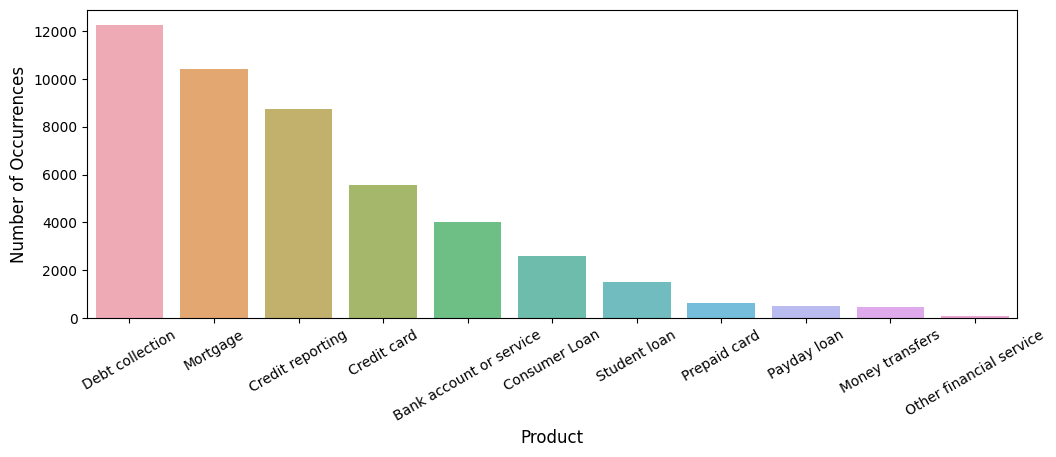

In [41]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [42]:
y_train['label'] = LabelEncoder().fit_transform(y_train['product'])

In [43]:
y_train_LE = y_train.drop(['product'], axis=1)

In [44]:
y_train_LE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   46764 non-null  int32
dtypes: int32(1)
memory usage: 182.8 KB


In [45]:
# Save label-encoded target labels
y_train_LE.to_parquet('./input/y_targets/y_train_LE.parquet')

In [46]:
# Drop original and label-encoded target dataframes from memory to mitigate potential data leakage
y_list = [y_train, y_train_LE]
del y_train, y_train_LE
del y_list

## Convert date values with datetime and create new feature for time between date_received and date_sent_to_company 

In [47]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df_train['date_received'] = np.where(
    pd.isna(df_train['date_received']) == False,
    pd.to_datetime(df_train['date_received'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [48]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df_train['date_sent_to_company'] = np.where(
    pd.isna(df_train['date_sent_to_company']) == False,
    pd.to_datetime(df_train['date_sent_to_company'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [49]:
# Create new feature that is the difference in days between when a complaint was received and when it was sent to company
df_train['days_between_receipt_and_sent'] = np.where(
    (pd.isna(df_train['date_received']) == False) & (pd.isna(df_train['date_sent_to_company']) == False),
    (df_train['date_sent_to_company'] - df_train['date_received']).dt.days,
    None
)

In [50]:
# Change new feature from datetime object to integer
df_train['days_between_receipt_and_sent'] = pd.to_numeric(df_train['days_between_receipt_and_sent'])

## Frequency encode 'sub_product' variable and add flag variables for missing/low-occurring

In [51]:
sub_product_freq = df_train.groupby('sub_product').size() / len(df_train)

In [52]:
# Vectorized operation to frequency encode sub_product category
df_train['sub_product_freq'] = np.where(
    pd.isna(df_train['sub_product']) == False,
    df_train['sub_product'].map(sub_product_freq),
    -1
)

In [53]:
# Vectorized operation to create binary flag variable for missing sub_product
df_train['sub_product_null_flag'] = np.where(
    pd.isna(df_train['sub_product']) == True,
    1,
    0
)

In [54]:
# Vectorized operation to create binary flag variable for low-occuring sub_product
df_train['sub_product_low_flag'] = np.where(
    (df_train['sub_product_freq'] <= 0.01) & (pd.isna(df_train['sub_product']) == False),
    1,
    0
)

## Frequency encode 'issue' variable and add flag variable for low-occurring

In [55]:
issue_freq = df_train.groupby('issue').size() / len(df_train)

In [56]:
# Vectorized operation to frequency encode issue category
df_train['issue_freq'] = np.where(
    pd.isna(df_train['issue']) == False,
    df_train['issue'].map(issue_freq),
    -1
)

In [57]:
# Vectorized operation to create binary flag variable for low-occuring issue
df_train['issue_low_flag'] = np.where(
    (df_train['issue_freq'] <= 0.01) & (pd.isna(df_train['issue']) == False),
    1,
    0
)

## Frequency encode 'sub_issue' variable and add flag variables for missing/low-occurring

In [58]:
sub_issue_freq = df_train.groupby('sub_issue').size() / len(df_train)

In [59]:
# Vectorized operation to frequency encode sub_issue category
df_train['sub_issue_freq'] = np.where(
    pd.isna(df_train['sub_issue']) == False,
    df_train['sub_issue'].map(sub_issue_freq),
    -1
)

In [60]:
# Vectorized operation to create binary flag variable for missing sub_issue
df_train['sub_issue_null_flag'] = np.where(
    pd.isna(df_train['sub_issue']) == True,
    1,
    0
)

In [61]:
# Vectorized operation to create binary flag variable for low-occuring sub_issue
df_train['sub_issue_low_flag'] = np.where(
    (df_train['sub_issue_freq'] <= 0.01) & (pd.isna(df_train['sub_issue']) == False),
    1,
    0
)

## Frequency encode 'company_public_response' variable and add flag variables for missing/low-occurring

In [62]:
company_public_response_freq = df_train.groupby('company_public_response').size() / len(df_train)

In [63]:
# Vectorized operation to frequency encode company_public_response category
df_train['company_public_response_freq'] = np.where(
    pd.isna(df_train['company_public_response']) == False,
    df_train['company_public_response'].map(company_public_response_freq),
    -1
)

In [64]:
# Vectorized operation to create binary flag variable for missing company_public_response
df_train['company_public_response_null_flag'] = np.where(
    pd.isna(df_train['company_public_response']) == True,
    1,
    0
)

In [65]:
# Vectorized operation to create binary flag variable for low-occuring company_public_response
df_train['company_public_response_low_flag'] = np.where(
    (df_train['company_public_response_freq'] <= 0.01) & (pd.isna(df_train['company_public_response']) == False),
    1,
    0
)

## Frequency encode 'company' variable and add flag variable for low-occurring

In [66]:
company_freq = df_train.groupby('company').size() / len(df_train)

In [67]:
# Vectorized operation to frequency encode company category
df_train['company_freq'] = np.where(
    pd.isna(df_train['company']) == False,
    df_train['company'].map(company_freq),
    -1
)

In [68]:
# Vectorized operation to create binary flag variable for low-occuring company
df_train['company_low_flag'] = np.where(
    (df_train['company_freq'] <= 0.01) & (pd.isna(df_train['company']) == False),
    1,
    0
)

## Frequency encode 'state' variable and add flag variables for missing/low-occurring

In [69]:
state_freq = df_train.groupby('state').size() / len(df_train)

In [70]:
# Vectorized operation to frequency encode state category
df_train['state_freq'] = np.where(
    pd.isna(df_train['state']) == False,
    df_train['state'].map(state_freq),
    -1
)

In [71]:
# Vectorized operation to create binary flag variable for missing state
df_train['state_null_flag'] = np.where(
    pd.isna(df_train['state']) == True,
    1,
    0
)

In [72]:
# Vectorized operation to create binary flag variable for low-occuring state
df_train['state_low_flag'] = np.where(
    (df_train['state_freq'] <= 0.01) & (pd.isna(df_train['state']) == False),
    1,
    0
)

## Frequency encode 'zipcode' variable and add flag variables for missing/low-occurring

In [73]:
zipcode_freq = df_train.groupby('zipcode').size() / len(df_train)

In [74]:
# Vectorized operation to frequency encode zipcode category
df_train['zipcode_freq'] = np.where(
    pd.isna(df_train['zipcode']) == False,
    df_train['zipcode'].map(zipcode_freq),
    -1
)

In [75]:
# Vectorized operation to create binary flag variable for missing zipcode
df_train['zipcode_null_flag'] = np.where(
    pd.isna(df_train['zipcode']) == True,
    1,
    0
)

In [76]:
# Vectorized operation to create binary flag variable for low-occuring zipcode
df_train['zipcode_low_flag'] = np.where(
    (df_train['zipcode_freq'] <= 0.001) & (pd.isna(df_train['zipcode']) == False), # change from 0.01 to 0.001 since zips are all fairly low-occurring
    1,
    0
)

## One-hot encode 'tags' variable but change nulls to "Not Older American, Not Servicemember" first

In [77]:
df_train['tags'].fillna("Not Older American, Not Servicemember", inplace=True)

In [78]:
df_train['tags'].value_counts()

Not Older American, Not Servicemember    38812
Older American                            4253
Servicemember                             3131
Older American, Servicemember              568
Name: tags, dtype: int64

In [79]:
OH_encoder = OneHotEncoder(dtype='int')
tags_df_train = pd.DataFrame(OH_encoder.fit_transform(df_train[['tags']]).toarray(), columns=OH_encoder.categories_[0])

In [80]:
tags_df_train.head()

,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,0,0,1


In [81]:
df_train = df_train.join(tags_df_train)

## One-hot encode 'company_response_to_consumer' variable

In [82]:
df_train['company_response_to_consumer'].value_counts()

Closed with explanation            35619
Closed with non-monetary relief     6041
Closed with monetary relief         3469
Closed                              1267
Untimely response                    368
Name: company_response_to_consumer, dtype: int64

In [83]:
response_df_train = pd.DataFrame(OH_encoder.fit_transform(df_train[['company_response_to_consumer']]).toarray(), 
                    columns=OH_encoder.categories_[0])

In [84]:
response_df_train.head()

,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


In [85]:
df_train = df_train.join(response_df_train)

## Binary encode 'timely_response' variable

In [86]:
df_train['timely_response'].value_counts()

Yes    45233
No      1531
Name: timely_response, dtype: int64

In [87]:
# Vectorized operation to create binary flag variable for timely_response
df_train['timely_response'] = np.where(
    df_train['timely_response'].str.contains('Yes'),
    1,
    0
)

In [88]:
df_train['timely_response'].value_counts()

1    45233
0     1531
Name: timely_response, dtype: int64

## Binary encode 'consumer_disputed?' variable

In [89]:
df_train['consumer_disputed?'].value_counts()

No     35876
Yes    10888
Name: consumer_disputed?, dtype: int64

In [90]:
# Vectorized operation to create binary flag variable for consumer_disputed?
df_train['consumer_disputed?'] = np.where(
    df_train['consumer_disputed?'].str.contains('Yes'), 
    1,
    0
)

In [91]:
df_train['consumer_disputed?'].value_counts()

0    35876
1    10888
Name: consumer_disputed?, dtype: int64

In [92]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date_received                          46764 non-null  object 
 1   sub_product                            32446 non-null  object 
 2   issue                                  46764 non-null  object 
 3   sub_issue                              23052 non-null  object 
 4   consumer_complaint_narrative           46764 non-null  object 
 5   company_public_response                22930 non-null  object 
 6   company                                46764 non-null  object 
 7   state                                  46628 non-null  object 
 8   zipcode                                46626 non-null  object 
 9   tags                                   46764 non-null  object 
 10  date_sent_to_company                   46764 non-null  object 
 11  co

In [93]:
df_train.head()

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,2016-01-16,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",None,Nationstar Mortgage,MA,020XX,"Not Older American, Not Servicemember",2016-01-16,Closed with explanation,1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,2015-10-25,Other bank product/service,Deposits and withdrawals,None,"on XXXX XXXX, 2015 there was an ACH transactio...",None,Fifth Third Financial Corporation,FL,331XX,"Not Older American, Not Servicemember",2015-10-25,Closed with explanation,1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,2015-10-28,None,Billing disputes,None,My wife has not received a paper bill from Cha...,None,JPMorgan Chase & Co.,TN,381XX,"Not Older American, Not Servicemember",2015-10-28,Closed with explanation,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,2015-06-20,Auto,Taking/threatening an illegal action,Seized/Attempted to seize property,the company m & M funding has been harassing f...,None,"M & S FUNDING, INC.",CO,809XX,"Not Older American, Not Servicemember",2015-06-26,Closed with explanation,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,2016-03-09,Installment loan,Managing the loan or lease,None,Can my reverse mortgage lender refuse to conti...,Company has responded to the consumer and the ...,Wells Fargo & Company,ME,048XX,Servicemember,2016-03-10,Closed with explanation,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0


## Drop non-converted and unneeded columns to keep feature-engineered dataframe

In [95]:
# keep 'product' bc used LabelEncoder here but have used cat.code factorization previously
df_train_fe = df_train.drop(['date_received', 'sub_product', 'issue', 'sub_issue', 'company_public_response', 'company', 
                             'state', 'zipcode', 'tags', 'date_sent_to_company', 'company_response_to_consumer'], axis=1)

In [96]:
df_train_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           46764 non-null  object 
 1   timely_response                        46764 non-null  int32  
 2   consumer_disputed?                     46764 non-null  int32  
 3   days_between_receipt_and_sent          46764 non-null  int64  
 4   sub_product_freq                       46764 non-null  float64
 5   sub_product_null_flag                  46764 non-null  int32  
 6   sub_product_low_flag                   46764 non-null  int32  
 7   issue_freq                             46764 non-null  float64
 8   issue_low_flag                         46764 non-null  int32  
 9   sub_issue_freq                         46764 non-null  float64
 10  sub_issue_null_flag                    46764 non-null  int32  
 11  su

In [100]:
df_train_fe.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,"on XXXX XXXX, 2015 there was an ACH transactio...",1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,My wife has not received a paper bill from Cha...,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,the company m & M funding has been harassing f...,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,Can my reverse mortgage lender refuse to conti...,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0


## Use profile report on feature-engineered dataframe

In [97]:
FE_profile_training = ProfileReport(df_train_fe, title="Feature-Engineered Consumer Complaints Profiling Report for Training Dataset")

In [98]:
# save EDA profile report to separate html
FE_profile_training.to_file("./EDA/profile_reports/01_FE_consumer_complaints_EDA_profiling_report_training.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Miniconda\envs\tf\lib\site-packages\multimethod\__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Save munged and feature-engineered dataframe for modeling

In [101]:
df_train_fe.to_parquet('./input/dataframes/df_train_FE.parquet')

## Save munged and select feature-engineered dataframe for modeling